In [1]:
%matplotlib inline

### Imports

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

### Useful functions to retrive the data

In [3]:
# create a annotations_file.csv (img -> img, label)

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            ret[img] = [img, index]
    
    return pd.Series(ret)

In [4]:
# create the pool of images (with a series that contains all the images, more deeply: img_name -> abs path, label, class)

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[img] = [abs_path, index, d]
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

In [5]:
wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, num_of_channels=3):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.noc = num_of_channels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx][0]
        try: 
            image = read_image(self.images.loc[img_name][0])
        except Exception:
            # print('Found error at {} - {}'.format(self.images.loc[img_name][0], self.img_labels.iloc[idx][1]))
            wrong_images_path.append(self.images.loc[img_name][0])
            return torch.zeros((600, 600, 1)), -1
        # image = read_image(self.images.loc[img_name][0])
        #? ask if this below is correct when channels == 4
        if image.shape[0] >= 3 and self.noc == 1: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        if image.shape[0] == 1 and self.noc == 3: #coloring grayscaled img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        image = Resize((600, 600))(image)
        image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.iloc[idx][1]
        return image, label

### Creating the 2 dataset and testing

In [6]:
train_path = './data/car_brand_logos/Train/'
test_path = './data/car_brand_logos/Test/'

# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=1)
test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=1)

In [7]:
# for i in range(train_data.__len__()):
#     img, label = train_data[i]

# for i in range(test_data.__len__()):
#     img, label = test_data[i]
    
    
# wrong_images_path

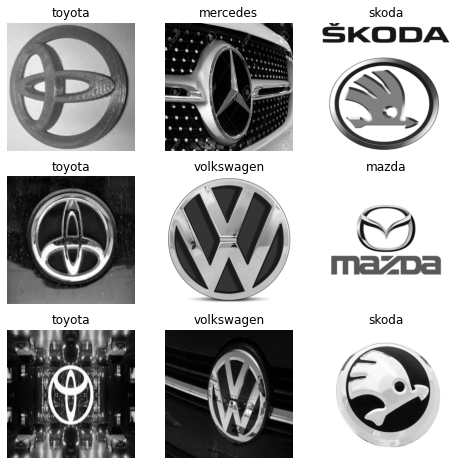

In [8]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
i=0
for d in only_dirs:
    diz[i] = d
    i+=1
    
diz[-1] = "Error"

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

In [9]:
# img, label = train_data[300]

# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray')

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([64, 600, 600, 1])
Labels batch shape: torch.Size([64])


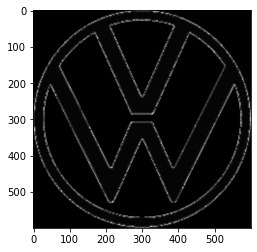

Label: volkswagen


In [10]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64, shuffle=True)

#dataloader test (ask a batch or a sample)

images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].squeeze() #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")

In [11]:
# os.rename('./data/car_brand_logos/Train/mercedes/r6.JPG', './data/car_brand_logos/Train/mercedes/r6.jpg')
# image = read_image('./data/car_brand_logos/Train/volkswagen/vosvos-volkswagen-logo-patches-arma-pec-kot-yamasi__1548797389090801.jpg')
# image = image.permute(1,2,0)
# plt.imshow(image, cmap='gray')
# plt.show()

### Defining the neural network

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #conv1: 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        # an affine operation: y = Wx + b
        self.fc_layer1 = nn.Linear(10 * 5 * 5, 120)  #? 10 -> output conv == input layer1
                                                    #? 600 --> image dimension (or 600*600)
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, i) # i is the num of classes

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [19]:
net = Net()
# net.to(device)

C:\Users\eliad\miniconda3\envs\tesi\lib\site-packages\torch\nn\init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [20]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
#? what's momentum and lr? are they important?
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training the network

In [22]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.permute(0, 3, 1, 2) # to get a shape of [64, 1, 600, 600]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x216090 and 250x120)

In [ ]:
#saving the trained model
PATH = './trained/auto_brand.pth'
torch.save(net.state_dict(), PATH)